In [2]:
import numpy as np
import control as con
from numpy import linalg as LA

import cvxpy
import optim_tools as optim_tools#own file with helper

In [135]:
###########################
# Hydraulischer Aktor     #
###########################

A0 = np.matrix([[0,   1,       0],
                [-10, -1.167, 25],
                [0,   0,    -0.8]])
print "Eigenvalues: {}".format(LA.eigvals(A0))
#a = -A[-1,:].T ### !!!!!
#print a
b0 = np.matrix([[0],[0],[2.4]])
c0 = np.matrix([1, 0, 0])
d0 = np.matrix([0])
u_max = 10.5
n = 3

X00 = [np.matrix([-20.0, -10.0, -10.0]).T,
       np.matrix([-20.0, -10.0, 10.0]).T,
       np.matrix([-20.0,  10.0, -10.0]).T,
       np.matrix([20.0,  -10.0, 10.0]).T,
       np.matrix([20.0,  -10.0, -10.0]).T,
       np.matrix([20.0,   10.0, 10.0]).T]

#print "A:\n", A
#print "a:\n", a
#print "b:\n", b
#print "c:\n", c

# Convert to Normalform
(A1, b1, c1, d1), T1, Q1 = optim_tools.get_Steuerungsnormalform(A0, b0, c0.T, d0)
a1 = -A1[-1][:].T #!!!!
print "T1:\n", T1

# Convert to Normalform
ss, T2 = con.canonical_form(con.ss(A0, b0, c0, d0), form='reachable')

assert np.allclose(T1*X00[1],
                   optim_tools.reverse_x_order(T2*X00[1])), "own Steuerungsnormalform Transformation not equal python control version"
#print "x_r1:\n", T1*X00[1]
#print "x_r2(backwards):\n", optim_tools.reverse_x_order(T2*X00[1])

A = optim_tools.reverse_x_order(np.matrix(ss.A))
a = -A[-1][:].T #!!!!

b = optim_tools.reverse_x_order(np.matrix(ss.B))
c = optim_tools.reverse_x_order(np.matrix(ss.C))
d = optim_tools.reverse_x_order(np.matrix(ss.D)) # == 0!

print "A:\n", A
assert np.allclose(A, A1)
print "a:\n", a
assert np.allclose(a, a1)
print "b:\n", b
assert np.allclose(b, b1)
print "c:\n", c
assert np.allclose(c, c1.T)

X0 = [T1.dot(x0) for x0 in X00]
print "X0:\n", X0
#print "A1:\n", A1
#print "a1:\n", a1
#print "b1:\n", b1
#print "c1:\n", c1

Eigenvalues: [-0.5835+3.10797808j -0.5835-3.10797808j -0.8000+0.j        ]
T1:
[[ 0.01666667  0.          0.        ]
 [ 0.          0.01666667  0.        ]
 [-0.16666667 -0.01945     0.41666667]]
A:
[[  0.       1.       0.    ]
 [  0.       0.       1.    ]
 [ -8.     -10.9336  -1.967 ]]
a:
[[  8.    ]
 [ 10.9336]
 [  1.967 ]]
b:
[[ 0.]
 [ 0.]
 [ 1.]]
c:
[[  6.00000000e+01   1.33226763e-15   1.33226763e-15]]
X0:
[matrix([[-0.33333333],
        [-0.16666667],
        [-0.63883333]]), matrix([[-0.33333333],
        [-0.16666667],
        [ 7.6945    ]]), matrix([[-0.33333333],
        [ 0.16666667],
        [-1.02783333]]), matrix([[ 0.33333333],
        [-0.16666667],
        [ 1.02783333]]), matrix([[ 0.33333333],
        [-0.16666667],
        [-7.3055    ]]), matrix([[ 0.33333333],
        [ 0.16666667],
        [ 0.63883333]])]


In [ ]:
######################################################
# Helper for Constraint variant (4.65) -> Q_sum      #
######################################################

# TODO: Was ist m? Kann man das berechnen oder wird das festgelegt m<=2n-1, meistens n+1?

from scipy.special import comb as nchoosek # n Choose k (n ueber k)

def get_a_list(a, Q, z, m):
    n = len(a) # dim of a, z, Q(nxn)
    m = m # Is this to choose or somehow given?
    l = m+1 # length of the array with all a_i in it i:{0,m}
    H = lambda k: optim_tools._H(k, n) # Convinence function to fix n and make specialized H(k)
    N = optim_tools._N(n)

    a_list = [np.zeros((n, n))] * l
    for i in range(0, l): # m eingeschlossen
        if i <= (m-1)/2.0: # 0 <= i <= (m-1)/2
            for k in range(1, i+1):
                a_list[i] += a.T * H(n+k-i)*Q*N*H(n-k+1)*a - z.T*N*H(n-i)*a
        elif i <= m: # (m-1)/2 < i <=m
            for k in range(1, 2*n-i+1):
                a_list[i] += a.T * H(k)*Q*N*H(2*n-i-k+1)*a
        else:
            # this branch is currently not possible in this program
            print "i={} < m={}".format(i, m)
            a_list[i] = 0
            
    return a_list


def trans_a_list(a_list, eps):
    l = len(a_list)
    m = l-1 #biggest index in a_list
    a1_list = [np.zeros(a_list[0].shape)] * l
    for j in range(0, l): #for each in a_list
        for i in range(j, l): # for each coefficient including m
            a1_list[j] += nchoosek(i, i-j) * ((1.0+eps)/(1.0-eps))**(i-j) * ((1.0-eps)/(2.0))**i * a_list[i]
    return a1_list

def calc_a_Sum(a_list):
    l = len(a_list) # number of matrizen in a_list
    m = l-1 # Index of Q_m
    n = a_list[0].size[0] # shape of each matrix, first element
    
    if m is 0:
        a_sum = cvxpy.bmat([[2*a_list[0],   np.zeros(n)], 
                            [np.zeros(n), np.zeros(n)]])
    elif m is 1:
        a_sum = cvxpy.bmat([[2*a_list[0], a_list[1]],
                            [a_list[1],   np.zeros(n)]])
    else: # e.g. m is 2 or more
        a_sum = cvxpy.bmat([[2*a_list[0], a_list[1]],
                            [a_list[1], 2*a_list[2]]])

    for i1 in range(3, l, 2):
        S_new_col = cvxpy.vstack(np.zeros((((i1+1)/2-1)*n, n)), a_list[i1])

        if i1 is m:
            S_new_row = cvxpy.hstack(np.zeros((n, ((i1+1)/2-1)*n)), a_list[i1], np.zeros((n,n)))
        else:
            S_new_row = cvxpy.hstack(np.zeros((n, ((i1+1)/2-1)*n)), a_list[i1], 2*a_list[i1+1])

        a_sum = cvxpy.bmat([[a_sum, S_new_col],
                            [S_new_row]])

    a_sum = -0.5*a_sum
    
    return a_sum

def calc_lmi_cond(a_sum, n):
    k = a_sum.size[1] / n # This dimension is from Boris. Dilyana does not specifiy the dimension though

    J = np.hstack([np.zeros((n*(k-1), n)), np.eye(n*(k-1))])
    C = np.hstack([np.eye(n*(k-1)), np.zeros((n*(k-1), n))])
    return np.vstack([C, J]), n*(k-1)

In [ ]:
##############################
# Convex Problem (4.58)      #
##############################

# Variables
Q  = cvxpy.Variable(n,n) # Implys (459) (semidefinite for numerical reasons?)

z = cvxpy.Variable(n)

# Constants
N = optim_tools._N(n)

# Constraints
constraint_459 = Q >> 0
constraint_460 = Q*(A.T + a*b.T) + (A + b*a.T)*Q - z*b.T - b*z.T << 0
constraint_461 = Q*N+N*Q << 0

constraint_462 = [cvxpy.bmat([[1,       X0[i].T],
                              [X0[i],    Q      ]]) >> 0
                                for i in range(0, len(X0))]

constraint_463 = cvxpy.bmat([[u_max**2 - a.T*Q*a + 2*a.T*z, z.T],
                             [z,                           Q  ]]) >> 0


# Collection of all constraints
constraints = [constraint_460] # -> for some objectives this constraint is replaced, therefore constraints[0]==constraint_460
constraints.append(constraint_459)
constraints.append(constraint_461)
constraints.extend(constraint_462) ##!! Beware of the "extend" if input is array
constraints.append(constraint_463)


In [ ]:
###########################################
# Constraint variant (4.65) -> Q_sum      #
###########################################

m = n

# Preparation for constraint (4.65)
a_list = get_a_list(a, Q, z, m) # Matrizes of Polynom coefficients: S(p)=S_0 + S_1*p + ... S_n*p^n
a1_list = trans_a_list(a_list, 0.01) # Intervaltransformation p:[0,1] -> p1:[-1,1] (S1 -> S^tilde)
a1_sum = calc_a_Sum(a1_list) # S^tilde_sum Matrix (30)
CJ, l = calc_lmi_cond(a1_sum ,n) # "Selection matrizes" of (31), l=dimension of P and G

# Further variables of optimization
S = cvxpy.Variable(l,l) #symmetrical
G = cvxpy.Variable(l,l) #skew

# Constraints on new variables
constraint_G = G + G.T == 0 # skew symmetry
constraint_S = S == S.T # symmetry

# Actual constraint
constraint_465 = a1_sum << CJ.T * cvxpy.bmat([[-S,  G],
                                              [G.T, S]]) * CJ

# Appending all constraints to "problem"

constraints.append(constraint_G)
constraints.append(constraint_S)
constraints.append(constraint_465)

In [ ]:
print "TO FUTURE-ME!"
print "STOP! Please rethink and choose the following cells wisely!"
print "AND NOT ALL OF THEM!"

In [ ]:
###########################################
# Objective variant (4.66) -> max(det(Q)) #
# Volumenmaximierung -> geomean(Q)        #
###########################################

# Help variable to minimize geomean
#v = cvxpy.Variable(1)

# Objective representation
#constraint_obj_451 = v >= -cvxpy.geo_mean(Q)

#constraints.append(constraint_obj_451)

obj = cvxpy.Maximize(cvxpy.log_det(Q)) # Identical to geo_mean (in term of convexity and result)
#obj = cvxpy.Minimize(-cvxpy.geo_mean(Q)) # Not yet implemented

prob = cvxpy.Problem(obj, constraints)

# Solve the problem with SCS
prob.solve(solver=cvxpy.SCS, verbose=False, max_iters=2500)
print prob.status
Q.value

In [ ]:
print "Q:\n", Q.value
R1 = LA.inv(Q.value)
print "R1:\n", R1

print "z:\n", z.value
a_hat = R1*z.value
print "a_hat:\n", a_hat

In [ ]:
########################
# Objective playground #
########################

#obj = cvxpy.Minimize(0) # Feasiblity
obj = cvxpy.Maximize(cvxpy.log_det(Q))
#obj = cvxpy.Maximize(cvxpy.lambda_min(Q))

prob = cvxpy.Problem(obj, constraints)

# Solve the problem with SCS
prob.solve(solver=cvxpy.SCS, verbose=False, max_iters=2500)
print prob.status
print "Q:\n", Q.value
print "R1:\n", LA.inv(Q.value)

In [ ]:
###########################################
# Objective variant (4.70)                #
# Max. Abklingrate                        #
###########################################

beta = cvxpy.Parameter(sign='positive') # Bisection parameter

constraint_obj_471 = Q*(A.T + a*b.T) + (A + b*a.T)*Q - z*b.T - b*z.T + 2*beta*Q << 0

constraints[0] = constraint_obj_471 # Replace constraint_460
obj = cvxpy.Minimize(0) # Feasiblity

prob = cvxpy.Problem(obj, constraints)

# Solve with bisection (and SCS)
[[Q_o, z_o], beta_o] = optim_tools.bisect_max(0, 10, prob, beta, [Q, z], solver=cvxpy.SCS)

print "Q:\n", Q_o
print "z:\n", z_o
print "beta:", beta_o

In [ ]:
print "Q:\n", Q_o
R1 = LA.inv(Q_o)
print "R1:\n", R1

print "z:\n", z_o
a_hat = R1*z_o
print "a_hat:\n", a_hat

In [ ]:
###########################################
# Objective variant (Kap. 4.5.3)          #
# Min. quad. Gütemaß                      #
# Nicht besonders gut laut Yankulova,     #
#  weil W gewählt werden muss             #
###########################################

gamma = cvxpy.Parameter(sign='positive') # Bisection parameter

# Further variables of optimization
W = cvxpy.Parameter(n, 1) # ~c -> Min(Integral{y.T*y}) -> Min(Integral{x.T*c.T*c*x}) -> Min(Integral{x.T*Ĝ*x})
W.value = np.matrix([1,0,0]).T # G=[1 0 0; 0 0 0; 0 0 0] ~~ c.T*c

# Constraints on new variables
#constraint_W = W*W.T >> 0 # symmetry ?
#print constraint_W

constraint_obj_xxx = cvxpy.bmat([[Q*(A.T + a*b.T) + (A + b*a.T)*Q - z*b.T - b*z.T, Q*W   ],
                                 [W.T*Q,                                           -gamma]]) << 0

constraints[0] = constraint_obj_xxx # Replace constraint_460
                                
obj = cvxpy.Minimize(0) # Feasiblity

prob = cvxpy.Problem(obj, constraints)


#gamma.value = 30.8990478516
#prob.solve(solver=cvxpy.SCS, verbose=True)

# Solve with bisection (and SCS)
[[Q_o, z_o], gamma_o] = optim_tools.bisect_min(20, 35, prob, gamma, [Q, z], solver=cvxpy.SCS, verbose=False)

print "Q:\n", Q_o
R1 = LA.inv(Q_o)
print "R1:\n", R1

print "z:\n", z_o
a_hat = R1*z_o
print "a_hat:\n", a_hat
print "gamma:", gamma_o

In [7]:
a_hat = np.matrix([[14.345160], [14.837268], [3.598276]])

R1 = np.matrix([[1.677977, 0.543373, 0.140299],
                  [0.543373, 0.32290,  0.062725],
                  [0.140298, 0.06272,  0.026148]])

Some checks for validy of solution

In [8]:
import numpy as np
print "Checking constraints (no output is ok!)"
eig_459 = np.linalg.eigvals(R1)
if np.any(eig_459 <= 0): print("Q not pos definit: {}".format(eig_459))

#eig_460 = np.linalg.eigvals((Q*(A.T+a*b.T)+(A+b*a.T)*Q-z*b.T-b*z.T).value)
#if np.any(eig_460 >= 0): print("4.60 not neg definit: {}".format(eig_460))

#eig_461 = np.linalg.eigvals((Q*N+N*Q).value)
#if np.any(eig_461 >= 0): print("4.61 not neg definit: {}".format(eig_461))



Checking constraints (no output is ok!)


In [10]:
T = np.arange(0, 5, 1e-2) 

#s: input, e.g., step function with amplitude of 0.2
s = np.zeros(len(T));

pmin = 0.0001
p_init = pmin

# Initial state
x0 = np.matrix([[20.],[10.],[10.]])

p_t = np.zeros(len(T))

Test k
[[ 1.]
 [ 2.]
 [ 3.]]


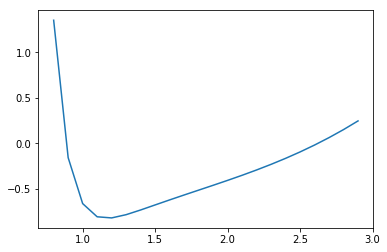

In [107]:
# Skalierte Version! aus Yankulova

# k(v) (4.5)
def get_k(v, a, a_hat):
    try:
        v = v.squeeze() # This is weird, needed for minimize for some reason
    except:
        pass
    D_inv = optim_tools._D_inv(v, len(a))
    #print D_inv
    k = D_inv.dot(a_hat) - a
    return k

print "Test k\n", get_k(0.2, np.matrix([124, 48, 12]).T, np.matrix([1, 2, 3]).T)
assert(np.allclose(-a+a_hat, get_k(1, a, a_hat)))

# Fixing a and a_hat for convinience
# func_k = lambda v: get_k(v, a, a_hat)

# G(v) (4.4)
def get_g(v, x, R1, u_max, a, a_hat):
    try:
        v = v.squeeze() # This is weird, needed for minimize for some reason
    except:
        pass
    D_inv = optim_tools._D_inv(v, len(x))
    R = D_inv.dot(R1).dot(D_inv) # R(v) = D^⁻1 * R1 * D^-1
    
    k = get_k(v, a, a_hat) # k(v)
    e = (u_max**(-2)) * (k.T.dot(LA.inv(R)).dot(k))
    #assert e < 1.0
    g = e*(x.T.dot(R).dot(x)) - 1.0
    #assert g <= 0, "g = {} > 0".format(g)
    # Update 2016: As of python 3.5, there is a new matrix_multiply symbol, @:
    # g = x' @ D^-1 @ R1 @ D^-1 @ x - 1.0
    return g
mi = 0.8
ma = 3

plt.plot(np.arange(mi, ma, 0.1), [get_g(p, T1*(x0), R1, u_max, a, a_hat).item(0) for p in np.arange(mi, ma, 0.1)])
plt.show()

In [34]:
optim_tools._D_inv(0.1, 3).dot(np.matrix([1, 1, 1]).T)
print x0
u_max**2

[[ 20.]
 [ 10.]
 [ 10.]]


110.25

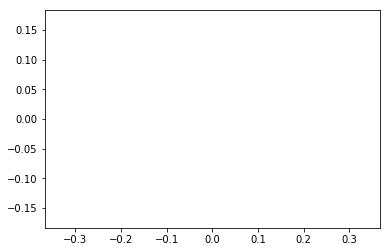

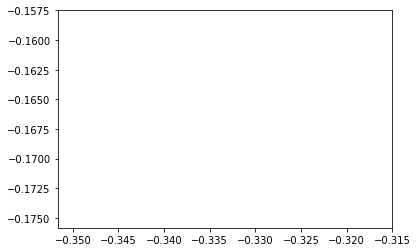

-0.333333333333 -0.166666666667


In [179]:
def insideX0(x, X0):
    pass
#plt.plot([x for x in np.arange(-1, 1, 0.1)], 1+np.zeros((len(np.arange(-1, 1, 0.1)), 1)))
for x0 in X0:
    for x1 in X0:
        plt.plot(x0[0,:], x1[1,:], 'k-')

#plt.plot(X0[0][0,:], X0[2][1,:], 'k-')

plt.show()
plt.plot([X0[0][0,:].item(0)], [X0[1][1,:].item(0)], 'k-')
plt.show()

print X0[0][0,:].item(0), X0[1][1,:].item(0)


In [136]:
from scipy.optimize import minimize
last_p = p_init

from IPython.display import clear_output

def contr_func(y, s, x, u_max, a, a_hat, T1=None):
    global last_p, pmin
    # Transformation in Regelungsnormalform
    if T1 is None:
        t1 = np.eye(len(x))
    # fill-in K matrix euation.
    ## Calc p
    #print "x:",x
    func_g = lambda p: get_g(p, x, R1, u_max, a, a_hat)
    res = minimize(func_g, last_p, method='Nelder-Mead')
    # Saturate if too small
    if res.x < pmin:
        p = pmin
    elif res.x > 1.0:
        p = 1.0
    else:
        p = res.x
        '''
        mi = pmin
        ma = 1

        plt.plot(np.arange(mi, ma, 0.1), [get_g(p1, x, R1, u_max, a, a_hat).item(0) for p1 in np.arange(mi, ma, 0.1)])
        plt.plot(p, get_g(p, x, R1, u_max, a, a_hat).item(0), 'ro')
        plt.show()
        raw_input()
        clear_output()        
        '''

    #p_t[t] = p
    #print "p:", p
    last_p = p
    
    ## Calc K according to p
    K = func_k(p)

    #print "K:", K
    #print "K.shape:", K.shape
    #print "s:", s
    
    # Calc u
    u = s-K.T.dot(x)
    
    # Saturate u
    u = optim_tools.sat(u, u_max)
    #print "u", u
    
    return u

In [99]:
get_k(1., a, a_hat)
print a

l1 = -0.8 
l2 = -0.584 + 3.108j
l3 = -0.584 - 3.108j

print np.poly([l1, l2, l3])[1:]

[[  8.    ]
 [ 10.9336]
 [  1.967 ]]
[  1.968     10.93512    8.000576]


In [109]:
y, u, u_sat = optim_tools.simulate(A1, b1, c1.T, d1, lambda y, s, x: contr_func(y, s, x, u_max, a, a_hat), s, T, umax=u_max, x0=T1*x0)
y2, u2, u2_sat = optim_tools.simulate(A1, b1, c1.T, d1, lambda y, s, x: s-get_k(1, a, a_hat).T.dot(x), s, T, umax=u_max, x0=T1*x0)
y3, u3, u3_sat = optim_tools.simulate(A0, b0, c0, d0, lambda y, s, x: s-np.matrix([-0.0833, 0.0828, 0.76068]).dot(x), s, T, umax= u_max, x0=x0)
y4, u4, u4_sat = optim_tools.simulate(A0, b0, c0, d0, lambda y, s, x: s-np.matrix([13.25659, 7.097648, 4.0502]).dot(x), s, T, umax= u_max, x0=x0)

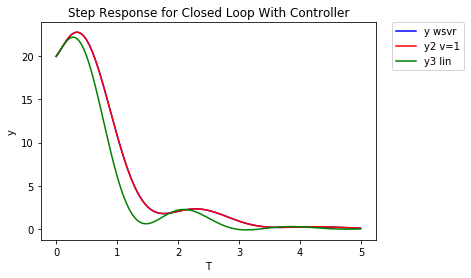

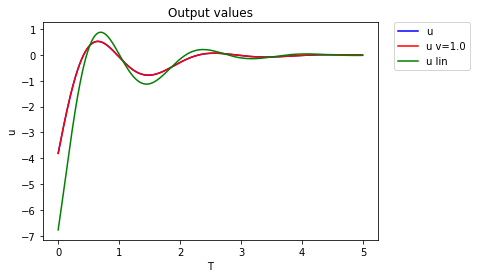

In [110]:
import matplotlib.pyplot as plt

#plt.figure()
line1, = plt.plot(T[:], np.array(y[0,:].T), 'b', label='y wsvr')
line2, = plt.plot(T[:], np.array(y2[0,:].T), 'r-', label='y2 v=1')
line3, = plt.plot(T[:], np.array(y3[0,:].T), 'g-', label='y3 lin')
#line4, = plt.plot(T[:], np.array(y4[0,:].T), 'g.-', label='y4 lin, apx evo')



#first_legend = plt.legend(handles=[line1], loc=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('y')
plt.title('Step Response for Closed Loop With Controller')
plt.show()

#plt.figure()
line1, = plt.plot(T, u_sat, 'b', label='u')
#line1b, = plt.plot(T, u, 'b.-', label='u')
line2, = plt.plot(T, u2_sat, 'r', label='u v=1.0')
#line2b, = plt.plot(T, u2, 'r.-', label='u fixed')
line3, = plt.plot(T, u3_sat, 'g', label='u lin')
#line3b, = plt.plot(T, u2, 'g.-', label='u lin')
#line4, = plt.plot(T, u4_sat, 'g.-', label='u lin, apx evo')


#>first_legend = plt.legend(handles=[line1, line2, line1b, line2b], loc=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('u')
plt.title('Output values')
plt.show()

In [ ]:
#plt.figure()
line1, = plt.plot(T, np.array(y[0,:].T), 'b')
line2, = plt.plot(T, u_sat, 'r', label='u')
#first_legend = plt.legend(handles=[line1], loc=1)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('y')
plt.title('Step Responce for Closed Loop With Controller')
plt.show()